### Notebook for testing model functions with input data and examining output

To do:
* Have started adding in the in-stream equations: continue with this on Tuesday.  
* Note: current land phase model uses a sustainable flow parameter, as in INCA. This is a fudge and needs
replacing

In [73]:
# Import modules
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, emcee, corner, mpld3
from scipy import optimize
import numpy as np, pandas as pd
from scipy.integrate import odeint
from scipy.stats import norm
sn.set_context('notebook')

In [74]:
# SNOW ACCUMULATION AND MELT

# Source for priors for DDF: http://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=17753.wba
# To Do:
# (1) Add options for how temperature is assumed to vary through the day. At the moment, assume average
# temperature throughout the day. In future, could look at triangular or sinuosoidal variations throughout
# the day, to get a more accurate portrayal of the degree-days above the threshold.
# Also assumes no melting below 0 deg C.

# (2) Consider setting ET to 0 when D_snow > 0.

def hydrol_inputs(D_snow_0, f_DDSM, met_df):
    """Function to calculate snow accumulation and melt.
    Calculates total hydrological input to soil box as precipitation as precipitation as rain + snowmelt
    
    D_snow_0: Initial snow depth (mm)
    f_DDSM: Degree-day factor for snow melt (mm/degree-day deg C)
    met_df: Dataframe of met data with cols T_air, PET, Pptn
    
    Returns met_df with additional columns [P_snow, P_rain, P_melt, D_snow_start
    D_snow_end, P]
    
    Of these, P is the hydrological input to the soil store
    """

    # Calculate precipitation falling as snow and add to met_df
    met_df.loc[:,'P_snow'] = met_df['Pptn'].ix[met_df['T_air']<0]
    met_df['P_snow'].fillna(0, inplace=True)

    # Calculate precipitation falling as rain and add to met_df
    met_df['P_rain'] = met_df['Pptn'] - met_df['P_snow']

    # Calculate daily snow melt, if unlimited snow pack depth to melt (mm/day)
    met_df['P_melt'] = f_DDSM*(met_df['T_air']-0)
    met_df['P_melt'][met_df['P_melt']<0]=0  # Set negative values to 0

    # Calculate snow pack depth
    met_df['D_snow_start'] = np.nan
    met_df['D_snow_end'] = np.nan

    # First time-step manually, to take initial condition into account
    met_df.ix[0,'D_snow_start'] = D_snow_0 #Assign start snow depth to first row
    met_df.ix[0,'P_melt'] = np.minimum(met_df.ix[0,'P_melt'],met_df.ix[0,'D_snow_start'])
    met_df.ix[0,'D_snow_end'] = met_df.ix[0,'D_snow_start']+met_df.ix[0,'P_snow']-met_df.ix[0,'P_melt']

    # Calculte for subsequent days
    for idx in range (1,len(met_df)):
        met_df.ix[idx,'D_snow_start'] = met_df.ix[idx-1,'D_snow_end']
        met_df.ix[idx,'P_melt'] = np.minimum(met_df.ix[idx,'P_melt'],met_df.ix[idx,'D_snow_start'])
        met_df.ix[idx,'D_snow_end'] = met_df.ix[idx,'D_snow_start']+met_df.ix[idx,'P_snow']-met_df.ix[idx,'P_melt']

    # Hydrological input to soil box
    met_df.loc[:,'P'] = met_df['P_rain'] + met_df['P_melt']
    
    return met_df

In [75]:
def hydro_model_5(met_df, ics, p, period, step_len=1):
    """ The hydrological model

            met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
            ics            Vector of initial conditions [Vs0, Vg0]
            p              Series of parameter values (index = param name)
                           Includes the extra param q_gw_min
            period         Vector of [start, end] dates [yyyy-mm-dd, yyyy-mm-dd]
            step_len       Length of each step in the input dataset (days)

        Returns a dataframe with column headings
        [Qq, Vs, Qs, Vg, Qg, Vr, Qr, Dr]
    """
    # ------------------------------------------------------------------------
    # Define the ODE system
    def f(y, t, ode_params):
        """ Define ODE system.
                y is list or variables for which we want to determine their value at the end of
                    the time step
                    [Vs, Qs, Vg, Qg, Vr, Qr, Dr]
                t is an array of time points of interest
                params is a tuple of input values & model params:
                    (P, E, Qq_i, f_IExcess, alpha, beta, T_s, T_g, fc, L_reach, a_Q, b_Q)
        """
        # Unpack incremental values for Qs and Qg from 
        Vs_i = y[0]
        Qs_i = y[1]
        Qg_i = y[3]
        Qr_i = y[5]
        
        # Unpack params
        P, E, Qq_i, f_IExcess, alpha, beta, T_s, T_g, fc, L_reach, a_Q, b_Q = ode_params
    
        # Soil equations
        dQs_dV = (((Vs_i - fc)*np.exp(fc - Vs_i))/(T_s*((np.exp(fc-Vs_i) + 1)**2)))
        +(1/(T_s*(np.exp(fc-Vs_i) + 1)))
        dVs_dt = P*(1-f_IExcess) - alpha*E*(1 - np.exp(-0.02*Vs_i)) - Qs_i
        dQs_dt = dQs_dV*dVs_dt
        
        # Groundwater equations
        dQg_dt = (beta*Qs_i - Qg_i)/T_g
        dVg_dt = beta*Qs_i - Qg_i
        
        # Instream equations       
        # NB factor in dQr_dt converts units of instream velocity (aQ^b) from m/s to mm/day; L_reach is in mm
        dQr_dt = ((Qq_i + (1-beta)*Qs_i + Qg_i) - Qr_i)* a_Q*(Qr_i**b_Q)*(8.64*10**7)/((1-b_Q)*L_reach)
        dVr_dt = (Qq_i + (1-beta)*Qs_i + Qg_i) - Qr_i
        dDr_dt = Qr_i
        
        # Add results of equations to an array
        res = np.array([dVs_dt, dQs_dt, dVg_dt, dQg_dt, dVr_dt, dQr_dt, dDr_dt])
        
        return res
    # -------------------------------------------------------------------------

    # Unpack initial conditions (initial soil water volume, groundwater flow, instream flow)
#     Vs0, Vg0 = ics
    Vs0, Qg0, Qr0 = ics

    # Time points to evaluate ODEs at. We're only interested in the start and
    # the end of each step
    ti = [0, step_len]

    # Lists to store output
    output_ODEs = []
    output_rest = []

    # Loop over met data
    for idx in range(len(met_df)):

        # Get P and E for this day
        P = met_df.ix[idx, 'P']
        E = met_df.ix[idx, 'PET']

        # Calculate infiltration excess and add to results
        Qq_i = p['f_IExcess']*P
        output_rest.append(Qq_i)

        # Calculate additional initial conditions from user-input initial conditions
        Qs0 = (Vs0 - p['fc'])/(p['T_s']*(1 + np.exp(p['fc'] - Vs0)))
        Vg0 = Qg0 *p['T_g']
        Vr0 = (p['L_reach']/p['a_Q']) * Qr0**(1-p['b_Q']) # i.e. V=QT, where T=L/aQ^b

        # Vector of initial conditions (adding 0 for Dr0, daily mean instream Q)
        y0 = [Vs0, Qs0, Vg0, Qg0, Vr0, Qr0, 0.0]

        # Model parameters plus rainfall and ET, for input to solver
        ode_params = np.array([P, E, Qq_i, p['f_IExcess'],p['alpha'], p['beta'],
                               p['T_s'], p['T_g'], p['fc'], p['L_reach'], p['a_Q'], p['b_Q']])

        # Solve
        y = odeint(f, y0, ti, args=(ode_params,))

        # Extract values for end of step
        res = y[1]

        # Numerical errors may result in very tiny values <0
        # set these back to 0
        res[res<0] = 0
        output_ODEs.append(res)

        # Update initial conditions for next step
        Vs0 = res[0]
        # FUDGE to re-set groundwater to user-supplied min flow at start of each time step!!!
        if param_dict['Qg_min'] > res[3]:
            Qg0 = p['Qg_min']
        else:
            Qg0 = res[3]
#         Qg0 = res[3]
        Qr0 = res[5]

    # Build a dataframe of ODE results
    df1 = pd.DataFrame(data=np.vstack(output_ODEs),
                      columns=['Vs', 'Qs', 'Vg', 'Qg', 'Vr', 'Qr', 'Dr'],
                      index=met_df.index)
    
    # Dataframe of non ODE results
    df2 = pd.DataFrame(data=np.vstack(output_rest), columns=['Qq'],
                     index=met_df.index)

    # Concatenate results dataframes
    df = pd.concat([df1,df2], axis=1)

    return df

In [76]:
# USER INPUT

# Met and observed data file paths
metdata_fpath = r'M:\Working\NewModel\ModelInputs\Tar_AvMetData_1981-2010.csv'
obsdata_fpath = r'M:\Working\NewModel\ModelInputs\Coull_9amDailyMeanQ_oldRating.csv'
# obsdata_fpath = r'M:\Working\NewModel\ModelInputs\Coull_9amDailyMeanQ_newRating.csv'
# obsdata_fpath = r'M:\Working\NewModel\ModelInputs\Aboyne_9amDMF.csv'

# Simulation period
st_dt = '2004-01-01'  # Start date
end_dt = '2005-12-31' # End date

# Catchment area (m2) (Coull: 51.7E6; Aboyne: 73.7E6)
cat_area = 51.7E6

# Include snow melt and accumulation module?
inc_snowmelt = 1

# Snow melt parameters
D_snow_0 = 0.  # Initial snow depth (mm)
f_DDSM = 2.74 # Degree-day factor for snow melt (mm/degree-day deg C)

# Model parameters, including starting guesses for those being calibrated
# Units: L_reach in mm for now. a_Q and b_Q are for m/s vs m3/s, therefore convert in script for now.
param_dict = {'fc':290, 'beta':0.6, 'f_IExcess':0.015, 'alpha':0.90,
              'T_s':6.,'T_g':60., 'Qg_min':0.4, 'L_reach':10*10**6 , 'a_Q':0.5, 'b_Q':0.5}

# Initial conditions
Vs0_init = param_dict['fc']       # Initial soil volume (mm)
Qg0_init = 1.                 # Initial groundwater flow (mm/day)
Qr0_init = 1.                 # Initial area-normalised in-stream flow (mm/day)

In [77]:
# SET UP
ics=[Vs0_init, Qg0_init, Qr0_init]  # Initial conditions
period=[st_dt, end_dt]    # Simulation period

# Store parameter values in series, referenced by their names (the row indices)
p = pd.Series(param_dict)  # All params; cols = param names, one row with values

In [78]:
# READ IN INPUT DATA

met_df = pd.read_csv(metdata_fpath, parse_dates=True, dayfirst=True, index_col=0)
obs_df = pd.read_csv(obsdata_fpath, parse_dates=True, dayfirst=True, index_col=0)

# Truncate the met and observed data to the desired period
met_df = met_df.truncate(before=period[0], after=period[1])
obs_df = obs_df.truncate(before=period[0], after=period[1])

# Convert cumecs to mm per day
obs_df['Runoff_mm'] = obs_df['Q_cumecs']*60*60*24*1000/cat_area
del obs_df['Q_cumecs']

# Linear interpolation of any missing values
met_df.interpolate(method='linear', inplace=True)

In [79]:
# RUN MODEL

if inc_snowmelt == 1:
    met_df = hydrol_inputs(D_snow_0, f_DDSM, met_df)
else:
    met_df.rename(columns={'Pptn':'P'}, inplace=True)

df = hydro_model_5(met_df=met_df, ics=ics, p=p, period=period)


NSE: 0.671425201091
NSE on logs 0.772414000971


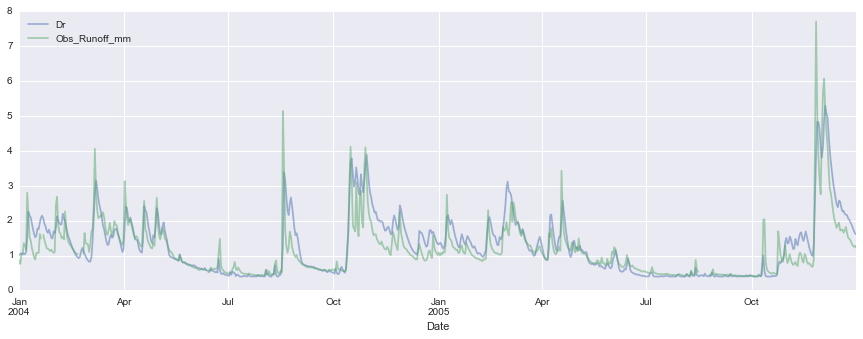

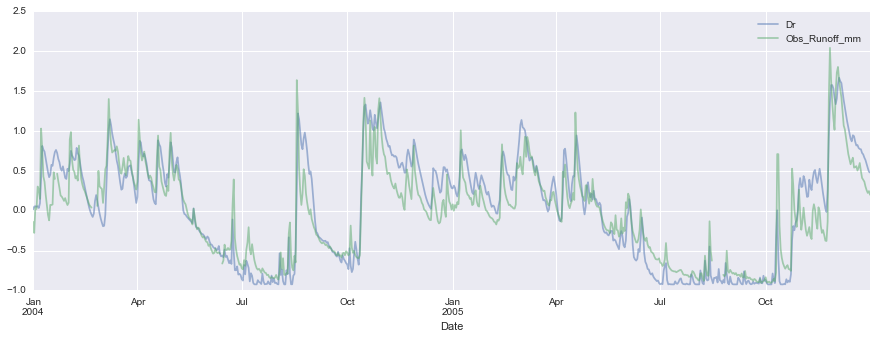

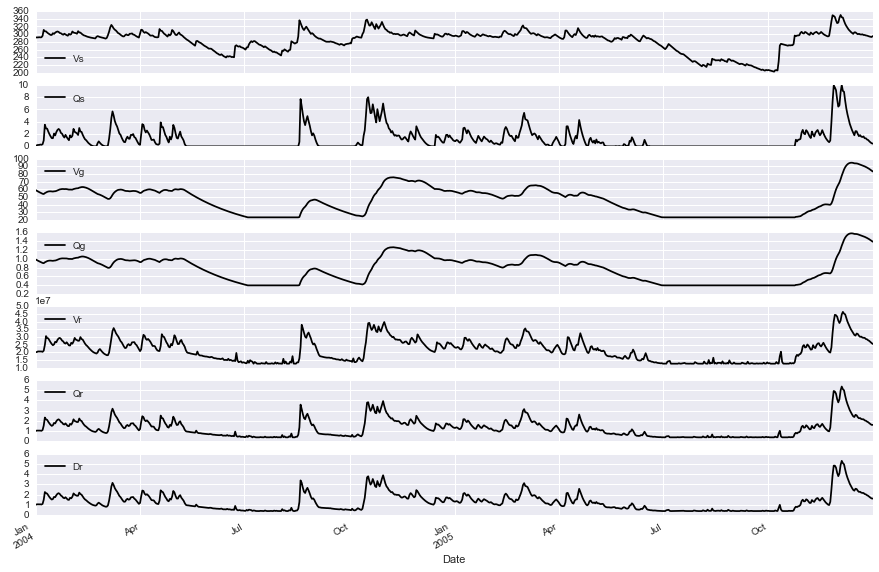

In [80]:
# EXAMINE OUTPUT

# Add observed runoff and snow depth to simulated df
df['Obs_Runoff_mm'] = obs_df['Runoff_mm']
df['D_snow'] = met_df['D_snow_end']

# Timeseries
# fig1 = df[['Sim_Runoff_mm_IE', 'Obs_Runoff_mm']].plot(alpha=0.5,figsize=(15, 5))
fig1 = df[['Dr', 'Obs_Runoff_mm']].plot(alpha=0.5,figsize=(15, 5))
# Plot on log scale
df_logs = np.log(df)
fig2 = df_logs[['Dr', 'Obs_Runoff_mm']].plot(alpha=0.5,figsize=(15, 5))
# fig3 = df[['Vs','Qs', 'Qg','Ds','Dg']].plot(subplots=True,figsize=(15, 10))
fig3 = df[['Vs','Qs', 'Vg','Qg','Vr','Qr','Dr']].plot(subplots=True,figsize=(15, 10))

# Print some stats
obs = df['Obs_Runoff_mm']
# sim_IE = df['Sim_Runoff_mm_IE']
# sim = df['Sim_Runoff_mm']
sim = df['Dr']
log_obs = np.log(obs)
log_sim = np.log(sim)

# NSE_IE = 1 - (np.sum((obs-sim_IE)**2)/np.sum((obs-np.mean(obs))**2))
# log_NSE_IE = 1 - (np.sum((log_obs-log_sim_IE)**2)/np.sum((log_obs-np.mean(log_obs))**2))

NSE = 1 - (np.sum((obs-sim)**2)/np.sum((obs-np.mean(obs))**2))
log_NSE = 1 - (np.sum((log_obs-log_sim)**2)/np.sum((log_obs-np.mean(log_obs))**2))

print "NSE:", NSE
print "NSE on logs", log_NSE

# print "NSE, no IE:", NSE
# print "NSE on logs, no IE:", log_NSE
# print "NSE, with IE:", NSE_IE
# print "NSE on logs, inc. IE:", log_NSE_IE

In [85]:
np.min((obs_df['Runoff_mm']/(60*60*24*1000)*cat_area))

0.24168488499999996